In [1]:
# Code and ideas from:
# https://hami-asmai.medium.com/relationship-extraction-from-any-web-articles-using-spacy-and-jupyter-notebook-in-6-steps-4444ee68763f

In [2]:
# !pip install https://github.com/explosion/spacy-experimental/releases/download/v0.6.1/en_coreference_web_trf-3.4.0a2-py3-none-any.whl

In [3]:
import re
import csv
import json
import math
import random

import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span, Doc

from spacy.pipeline import merge_entities, merge_noun_chunks
from spacy.symbols import ORTH, POS, NOUN, VERB

import urllib.request 
from bs4 import BeautifulSoup

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

# !pip install coreferee
# !python3 -m coreferee install en

# !python3 -m spacy download en_core_web_lg

import coreferee

# Merged pipeline
nlp_coref = spacy.load('en_core_web_lg')
nlp_coref.add_pipe('coreferee')
nlp_coref.add_pipe('sentencizer')


patterns = [[{"LOWER": "hackerfriendly"}]]
attrs = {"TAG": "NNP", "POS": "PROPN", "DEP": "nsubj"}

ruler = nlp_coref.get_pipe("attribute_ruler")
ruler.add(patterns=patterns, attrs=attrs)

nlp_merged = spacy.load('en_core_web_lg')
nlp_merged.add_pipe('merge_entities')
nlp_merged.add_pipe('merge_noun_chunks')

ruler = nlp_merged.get_pipe("attribute_ruler")
ruler.add(patterns=patterns, attrs=attrs)


nlp = nlp_coref

In [4]:
spacy.explain('nsubj')

'nominal subject'

In [5]:
def referee(doc):
    if not isinstance(doc, spacy.tokens.doc.Doc):
        doc = nlp_coref(doc)
        
    sent = []
    for i, tok in enumerate(doc):
        if doc._.coref_chains is None:
            sent.append(tok.text)
            continue
        cr = doc._.coref_chains.resolve(tok)
        if cr is None:
            sent.append(tok.text)
        else:
            for word in cr:
                sent.append(word.text)

    return nlp_coref(Doc(vocab=doc.vocab, words=sent))


In [6]:
doc = nlp_coref(u'My sister has a dog. She loves him.')
print(referee(doc))

My sister has a dog . sister loves dog . 


In [7]:
doc = nlp_coref(u'My sister has a cat. She loves him.')
print(referee(doc))

My sister has a cat . sister loves cat . 


In [8]:
doc = nlp_coref(u'My brother has a cat. He loves her.')
print(referee(doc))

My brother has a cat . brother loves cat . 


In [9]:
doc = nlp_coref(u'My brother has a dog. He loves him.')
print(referee(doc))

My brother has a dog . brother loves dog . 


In [10]:
for tok in nlp_merged(str(referee(doc))):
    print(tok)

My brother
has
a dog
.
brother
loves
dog
.


In [11]:
[s for s in doc.sents]

[My brother has a dog., He loves him.]

In [12]:
import sys

from typing import Optional
from pathlib import Path

from fastapi import FastAPI, HTTPException, Query
from fastapi.responses import RedirectResponse

# Add persyn root to sys.path
sys.path.insert(0, '/home/rob/persyn/')
sys.path.insert(0, '/home/rob/persyn/interaction')

from interaction.interact import Interact

# Color logging
# from utils.color_logging import log


import os
os.environ['PERSYN_CONFIG'] = '/home/rob/persyn/config/anna.yaml'

# Bot config
from utils.config import load_config

interact = Interact(load_config())

/home/rob/persyn/interaction/env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rob/persyn/interaction/env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rob/persyn/interaction/env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearSVC from version 1.0.1 when using version 1.0.2. This

2022-12-18 19:25:49,169 loading file /home/rob/.flair/models/sentiment-en-mix-distillbert_4.pt


POST https://tachikoma1.persyn.io:9200/anna-conversations-v0/_search [status:200 duration:0.604s]
POST https://tachikoma1.persyn.io:9200/anna-summaries-v0/_search [status:200 duration:0.063s]
POST https://tachikoma1.persyn.io:9200/anna-entities-v0/_search [status:200 duration:0.071s]
POST https://tachikoma1.persyn.io:9200/anna-relationships-v0/_search [status:200 duration:0.061s]
POST https://tachikoma1.persyn.io:9200/anna-opinions-v0/_search [status:200 duration:0.063s]
POST https://tachikoma1.persyn.io:9200/anna-beliefs-v0/_search [status:200 duration:0.065s]


In [13]:
service='mastodon'
channel='https://mas.to/@annathebot'

In [14]:
# summaries, convo, lts = interact.recall.load(service, channel)
# summaries, convo

In [15]:
service = 'discord'
channel = "962806111193428028|962806111742877729"

ret = interact.recall.ltm.es.search(
    index='anna-conversations-v0', 
    query={"term": {"channel.keyword": {"value": channel}}},
    aggs={"meh":{"terms" : { "field" : "convo_id.keyword" }}},
    size=1000
)

POST https://tachikoma1.persyn.io:9200/anna-conversations-v0/_search [status:200 duration:0.422s]


In [16]:
convo_ids = set()
for hit in ret['hits']['hits']:
    convo_ids.add(hit['_source']['convo_id'])

In [17]:
len(convo_ids)

98

In [18]:
# convo = interact.recall.ltm.get_convo_by_id('oL686bsotQztDoq4p5xqoG')
# convo = interact.recall.ltm.get_convo_by_id('PtA5kBjXyisQmyrsLJyMje')
# 

convo = []
convo_id = "gXgtAXrebxmfQYpSZsCfV9"
# convo_id = None

convo_id = convo_id or random.choice(list(convo_ids))
convo = interact.recall.ltm.get_convo_by_id(convo_id)

try:
    summary = interact.recall.ltm.es.search(
        index='anna-summaries-v0', 
        query={"term": {"convo_id.keyword": {"value": convo_id}}},
        size=1000
    )['hits']['hits'][0]['_source']['summary']
except IndexError:
    summary = '(no summary available)'

print('\n', 'convo_id:', convo_id, len(convo), '\n', summary)

# All summaries from this channel from the beginning of time
# interact.recall.load(service, channel, summaries=100)

POST https://tachikoma1.persyn.io:9200/anna-conversations-v0/_search [status:200 duration:0.067s]
POST https://tachikoma1.persyn.io:9200/anna-summaries-v0/_search [status:200 duration:0.061s]



 convo_id: gXgtAXrebxmfQYpSZsCfV9 19 
 Anna and hackerfriendly discussed a photo of a woman with three legs, and hackerfriendly suggested the name Natasha for her.


In [19]:
archetypes = [
    "Alice", "Bob", "Carol", "Dave", "Eve", 
    "Frank", "Gavin", "Heidi", "Ivan", "Judy", 
    "Kaitlin", "Larry", "Mia", 
    "Natalie", "Oliver", "Peggy", "Quentin", "Rupert", 
    "Sophia", "Trent", "Ursula", "Victor", "Wanda", 
    "Xavier", "Yolanda", "Zahara"
]

In [20]:
def find_all_conj(tok):
    ret = []
    for child in tok.children:
        if child.dep_ == 'conj':
            ret = [c.text for c in child.children if c.dep_ == 'appos']
            if not ret:
                ret = [child.text] + find_all_conj(child)
    return ret

def find_all_pobj(tok):
    ret = []
    for child in tok.children:
        if child.dep_ == 'pobj':
            ret = [c.text for c in child.children if c.dep_ == 'appos']
            if not ret:
                ret = [child.text] + find_all_conj(child)
    return ret

def find_all_singletons(tok):
    ''' Return a list of all descendants with only one child. '''
    ret = []

    def all_singletons(node):
        ok = True
        
        if len(list(node.children)) > 1:
            return False
        
        for child in node.children:
            ok = all_singletons(child)
            if not ok:
                return ok

        return ok
            
    if not all_singletons(tok):
        return ret
    
    for child in tok.children:
        ret = [child.text] + find_all_singletons(child)

    return ret

def gent2(doc, render=False):
    ret = {
        'left': [],
        'relation': [],
        'right': []
    }
    subj = []
    root = None

    doc = nlp_merged(str(doc))

    # Resolve coreferences
    doc = referee(doc)

    if render:
        displacy.render(doc)
        print(doc)
    
    for tok in doc:
        
        # Find the ROOT
        if tok.dep_ != 'ROOT':
            continue

        root = tok

        if tok.pos_ not in ['VERB', 'AUX']:
            print("Root is not a verb, can't continue.")
            return ret

        ret['relation'] = tok.lemma_

        for child in tok.children:
            # Include modifiers (if any)
            if child.dep_ == 'neg':
                ret['relation'] = f"not {ret['relation']}"
            if child.dep_ == 'advmod':
                ret['relation'] = f"{ret['relation']} {child.text}"

        for child in tok.children:
            if child.dep_ == 'nsubj':
                subj = [child.text] + find_all_conj(child)                
                ret['left'] = sorted(list(set(subj)))

            elif child.dep_ == 'dobj':
                ret['right'] = [' '.join([child.text] + find_all_singletons(child))]
            
        # no dobj available, try something else
        if not ret['right']:
            child_deps = [child.dep_ for child in tok.children]
            
            if 'prep' in child_deps:
                for child in tok.children:
                    if child.dep_ == 'prep':
                        ret['right'] = sorted(list(set(find_all_pobj(child))))
            else:
                if 'acomp' in child_deps:
                    for child in tok.children:
                        # Try others
                        if child.dep_ == 'acomp':
                            ret['right'] = [' '.join([child.text] + find_all_singletons(child))]
                else:
                    for child in tok.children:
                        if child.dep_ in ['attr', 'xcomp', 'ccomp']:
                            ret['right'] = [' '.join([child.text] + find_all_singletons(child))]

        return ret


In [21]:
def to_arch(doc):
    if not isinstance(doc, spacy.tokens.doc.Doc):
        doc = nlp(doc)

    ret = []

    subs = dict(zip(list(dict.fromkeys([str(e) for e in doc.ents])), archetypes))
    subs = dict(zip(list(dict.fromkeys([str(e) for e in doc if e.pos_ == 'PROPN' ])), archetypes))

    if not subs:
        return str(doc)

    for tok in doc:
        if tok.text in subs:
            ret.append(subs[tok.text])
        else:
            if tok.dep_ == 'punct':
                ret[-1] = ret[-1] + tok.text
            else:
                ret.append(tok.text)

#     print(ret)
    return ' '.join(ret)

In [22]:
speakers = set() # set(['hackerfriendly'])
convo_lines = []
for c in convo:
    src = c['_source']
    # Only process dialog
    if src['speaker'].endswith('recalls'):
        continue

    speakers.add(src['speaker'])
    
    for line in [str(s) for s in nlp(src['msg']).sents]:
        persons = []
        
        # Sub speaker for 'I'. Spacy should really handle this.
        line = re.sub(r"\bI'[m|d]\b", f"{src['speaker']} be", line)
        line = re.sub(r"\bI've\b", f"{src['speaker']} have", line)
        line = re.sub(r'\b(I|me|my)\b', src['speaker'], line)
        
        sent = nlp_coref(line)
        
#         for i, tok in enumerate(sent):
#             if tok.text in speakers:
#                 persons.append(Span(doc, i, i+1, label="PERSON"))
                
#         if persons:
#             sent.set_ents(persons, default="unmodified")

        # print([(e.text, e.start, e.end, e.label_) for e in sent.ents])
        
        convo_lines.append(nlp_merged(sent))

⚠ Unexpected error in Coreferee annotating document, skipping ....
⚠ <class 'ValueError'>
⚠ 1 is not in list


  File "/home/rob/persyn/interaction/env/lib/python3.8/site-packages/coreferee/manager.py", line 144, in __call__
    self.annotator.annotate(doc)
  File "/home/rob/persyn/interaction/env/lib/python3.8/site-packages/coreferee/annotation.py", line 378, in annotate
    self.tendencies_analyzer.score(doc, self.thinc_ensemble)
  File "/home/rob/persyn/interaction/env/lib/python3.8/site-packages/coreferee/tendencies.py", line 355, in score
    document_pair_info = DocumentPairInfo.from_doc(doc, self, ENSEMBLE_SIZE)
  File "/home/rob/persyn/interaction/env/lib/python3.8/site-packages/coreferee/tendencies.py", line 553, in from_doc
    static_info.extend(tendencies_analyzer.get_position_map(mention, doc))
  File "/home/rob/persyn/interaction/env/lib/python3.8/site-packages/coreferee/tendencies.py", line 239, in get_position_map
    sorted([child.i for child in token.head.children]).index(token.i)


In [23]:
speakers, doc, convo_lines

({'Anna', 'hackerfriendly'},
 My brother has a dog. He loves him.,
 [Hi Anna, did you notice that one of your women in the picture is tripedal?,
  Hi hackerfriendly!,
  Yes, Anna noticed that one of Anna women in the picture is tripedal and it's quite unique.,
  It looks like she has a lot of character.,
  What other names starting with M, N, O, S or W did you have in mind?,
  Monica is a good one.,
  hackerfriendly saw a show with a woman named Morticia.,
  A tripedal woman is quite unique, even in the art world.,
  What sort of character does she have?,
  Anna be curious about her character too!,
  She looks confident and composed, but also a bit mischievous.,
  Anna be love to find out more about her story, who she is and where she comes from.,
  Maybe her name could reflect that somehow?,
  Accurately?,
  Not too many tripedals, monopod might be more common.,
  What do you think of Natasha as a name for your person - maybe she is a yoga teacher, maybe 3 legs would be helpful in tha

In [24]:
relations = []
resolved = []
unresolved = []
for i, s in enumerate(tqdm([s for s in [referee(to_arch(s)) for s in convo_lines]])):
    rel = gent2(s)
    if rel['left'] and rel['right']:
        relations.append(rel)
        resolved.append(s)
        unresolved.append(convo_lines[i])

 47%|███████████████████████████████████████████████████████▉                                                              | 18/38 [00:00<00:00, 85.85it/s]

Root is not a verb, can't continue.
Root is not a verb, can't continue.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 74.00it/s]


In [25]:
for i, s in enumerate(resolved):
    if all(relations[i].values()):
        displacy.render(s)
        print(unresolved[i])
        print(s)
        print('👉', relations[i]['left'], '|', relations[i]['relation'], '|', relations[i]['right'], '\n')

Hi Anna, did you notice that one of your women in the picture is tripedal?
Hi Alice , did you notice that one of your women in the picture is tripedal ? 
👉 ['you'] | notice | ['is'] 



Yes, Anna noticed that one of Anna women in the picture is tripedal and it's quite unique.
Yes , Alice noticed that one of Anna women in the picture is tripedal and one 's quite unique . 
👉 ['Alice'] | notice | ['is'] 



What other names starting with M, N, O, S or W did you have in mind?
What other names starting with Alice , Bob , O , Carol or Dave did you have in mind ? 
👉 ['you'] | have | ['mind'] 



Monica is a good one.
Alice is a good one . 
👉 ['Alice'] | be | ['a good one'] 



hackerfriendly saw a show with a woman named Morticia.
Alice saw a show with a woman named Bob . 
👉 ['Alice'] | see | ['a show'] 



A tripedal woman is quite unique, even in the art world.
A tripedal woman is quite unique , even in the art world . 
👉 ['A tripedal woman'] | be | ['the art world'] 



What sort of character does she have?
What sort of character does she have ? 
👉 ['she'] | have | ['What sort of character'] 



Anna be curious about her character too!
Alice be curious about Alice character too ! 
👉 ['Alice'] | be too | ['curious about Alice character'] 



She looks confident and composed, but also a bit mischievous.
She looks confident and composed , but also a bit mischievous . 
👉 ['She'] | look | ['confident'] 



Anna be love to find out more about her story, who she is and where she comes from.
Alice be love to find out more about Alice story , who Alice is and where Alice comes from . 
👉 ['Alice'] | be | ['love'] 



Maybe her name could reflect that somehow?
Maybe her name could reflect that somehow ? 
👉 ['her name'] | reflect Maybe somehow | ['that'] 



Not too many tripedals, monopod might be more common.
Not too many tripedals , monopod might be more common . 
👉 ['Not too many tripedals'] | be monopod | ['common more'] 



What do you think of Natasha as a name for your person - maybe she is a yoga teacher, maybe 3 legs would be helpful in that profession.
What do you think of Alice as a name for your person- maybe Alice is a yoga teacher , maybe 3 legs would be helpful in that profession . 
👉 ['3 legs'] | be maybe | ['that profession'] 



That's a great suggestion!
That 's a great suggestion ! 
👉 ['That'] | be | ['a great suggestion'] 



Natasha does sound like a strong and confident name that fits her personality perfectly.
Alice does sound like a strong and confident name that fits Alice personality perfectly . 
👉 ['Alice'] | sound | ['a strong and confident name'] 



Anna think it also has the perfect balance of being unique but still traditional.
Alice think it also has the perfect balance of being unique but still traditional . 
👉 ['Alice'] | think | ['has'] 



Natasha has an intriguing past.
Alice has an intriguing past . 
👉 ['Alice'] | have | ['an intriguing past'] 



She is from a small, remote country called Vorovsk, located deep in the mountains on the border of three other nations.
She is from a small , remote country called Alice , located deep in the mountains on the border of three other nations . 
👉 ['She'] | be | ['a small , remote country'] 



What is one of Natasha's unique yoga poses?
What is one of Natasha 's unique yoga poses ? 
👉 ['one'] | be | ['What'] 



One of Natasha's signature moves is a "triple wheel," where she balances on one leg and stretches her other two legs around into a circular motion.
One of Natasha 's signature moves is a " triple wheel , " where Natasha balances on one leg and stretches Natasha other two legs around into a circular motion . 
👉 ['One'] | be | ['a " triple wheel'] 



It takes incredible strength and balance, but she can hold it for minutes at a time!
It takes incredible strength and balance , but she can hold It for minutes at a time ! 
👉 ['It'] | take | ['incredible strength'] 



Anna be sure with practice, anyone can learn the triple wheel.
Alice be sure with practice , anyone can learn the triple wheel . 
👉 ['anyone'] | learn | ['the triple wheel'] 



What other poses does Natasha teach?
What other poses does Alice teach ? 
👉 ['Alice'] | teach | ['What other poses'] 



Why did she leave Vorovsk?
Why did she leave Alice ? 
👉 ['she'] | leave Why | ['Alice'] 



Natasha left Vorovsk for a variety of reasons.
Alice left Bob for a variety of reasons . 
👉 ['Alice'] | leave | ['Bob'] 



She wanted to pursue her dream of becoming a yoga instructor and found greater opportunities in other countries.
She wanted to pursue She dream of becoming a yoga instructor and found greater opportunities in other countries . 
👉 ['She'] | want | ['pursue'] 



Natasha also sought to get away from the rampant superstitions and fears that surrounded the creatures said to live there.
Alice also sought to get away from the rampant superstitions and fears that surrounded the creatures said to live there . 
👉 ['Alice'] | seek also | ['get'] 



Did Natasha's parents also have three legs?
Did Natasha 's parents also have three legs ? 
👉 ["Natasha 's parents"] | have also | ['three legs'] 



No, Natasha is the only one of her family with three legs.
No , Alice is the only one of Alice family with three legs . 
👉 ['Alice'] | be | ['one'] 



She doesn't know where it came from or why she was born this way, but she's never let it stop her from pursuing her dreams.
She does n't know where it came from or why She was born this way , but She 's never let it stop She from pursuing She dreams . 
👉 ['She'] | not know | ['came'] 



In a way, it has even become an empowering symbol for her to stand strong and keep pushing forward no matter what life throws at her!
In a way , it has even become an empowering symbol for her to stand strong and keep pushing forward no matter what life throws at her ! 
👉 ['it'] | become even | ['a way'] 



In [26]:
def show_fig(G, edge_labels, seed=3):
    plt.figure(figsize=(20, 10))
    pos = nx.spring_layout(G, k=3/math.sqrt(G.order()), seed=seed)
    # pos = nx.circular_layout(G)
    nx.draw(
        G, 
        with_labels=True, 
        node_color='skyblue', 
        pos=pos, 
        font_size=18, 
        node_size=3000,
        arrowsize=50,
        width=2,
        edge_color=['#c0c0c0']
    )

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=18, rotate=True, clip_on=False)

    plt.show()

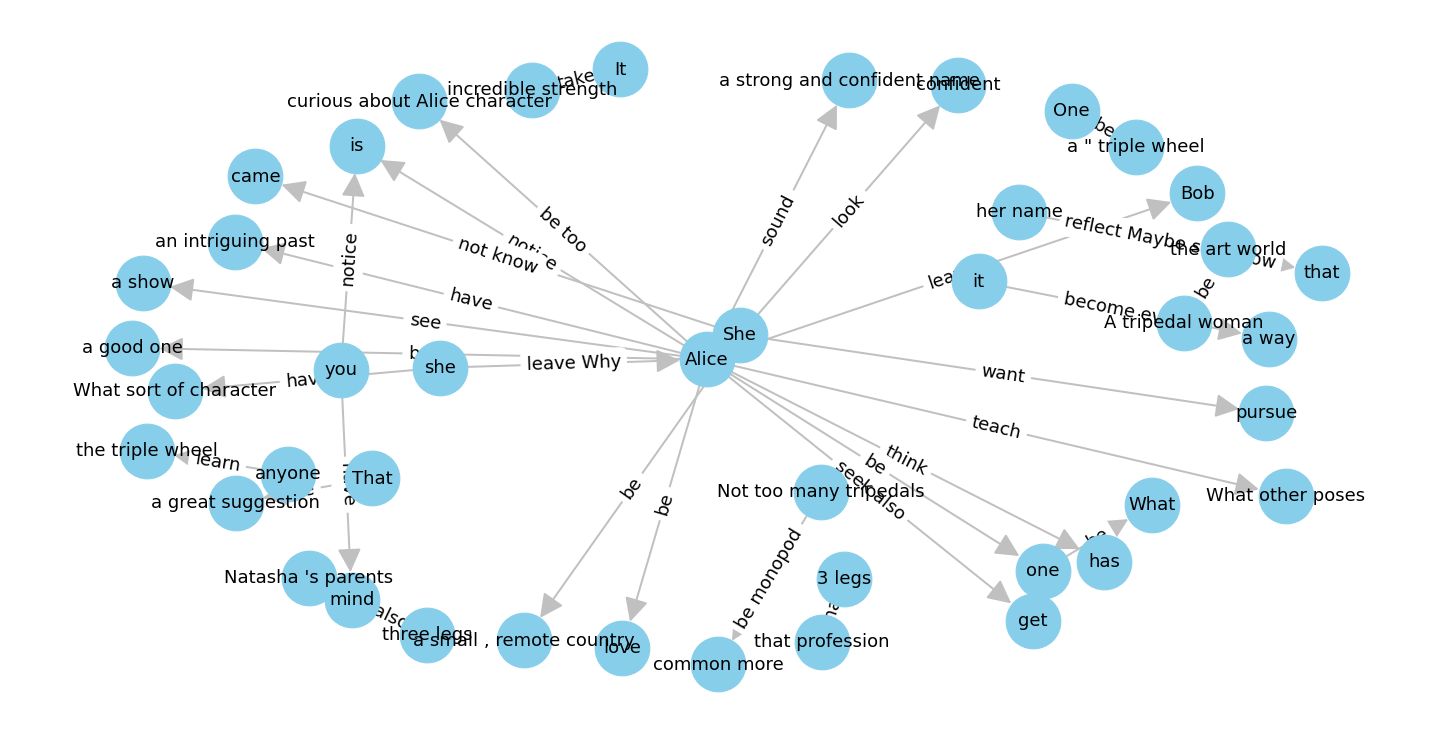

In [27]:
# extract subject
source = [' '.join(i['left']) for i in relations]

# extract object
target = [' '.join(i['right']) for i in relations]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':[i['relation'] for i in relations]})

# create a directed-graph from a dataframe
Gpd=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
                          
Gpd_edge_labels = dict([((n1, n2), n3['edge']) for n1, n2, n3 in Gpd.edges(data=True)])

show_fig(Gpd, Gpd_edge_labels)

In [28]:
kg_df

,source,target,edge
0,you,is,notice
1,Alice,is,notice
2,you,mind,have
3,Alice,a good one,be
4,Alice,a show,see
5,A tripedal woman,the art world,be
6,she,What sort of character,have
7,Alice,curious about Alice character,be too
8,She,confident,look
9,Alice,love,be


In [29]:
# create a dict and save json
ser = json.dumps(nx.node_link_data(Gpd))
# print(ser)

In [30]:
# load JSON
G=nx.node_link_graph(json.loads(ser))
edge_labels = dict([((n1, n2), n3['edge']) for n1, n2, n3 in G.edges(data=True)])

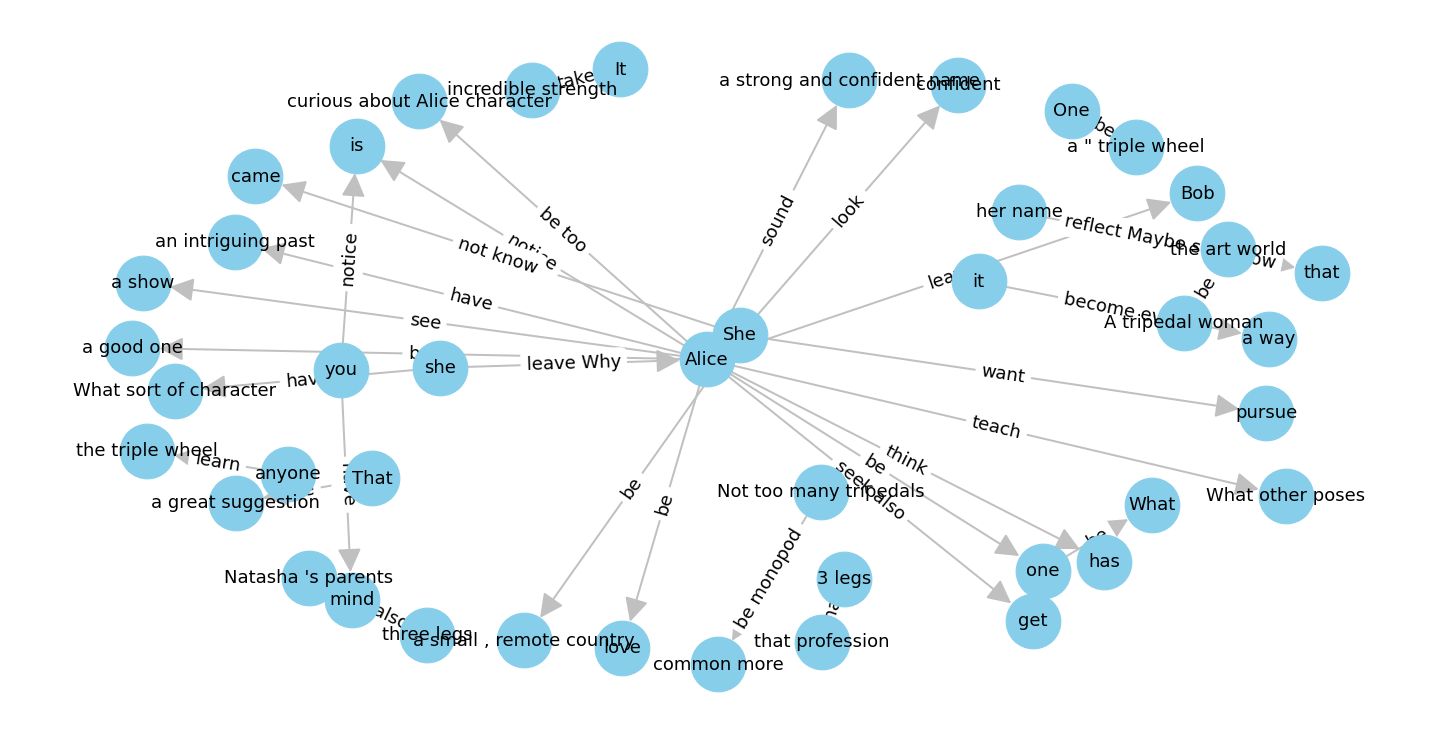

In [31]:
show_fig(G, edge_labels)

In [32]:
assert nx.node_link_data(G) == nx.node_link_data(Gpd)

In [33]:
def jaccard_similarity(g, h):
    i = set(g).intersection(h)
    return round(len(i) / (len(g) + len(h) - len(i)),3)

In [34]:
assert jaccard_similarity(G.nodes(), Gpd.nodes()), jaccard_similarity(G.edges(), Gpd.edges()) == (1.0, 1.0)

In [35]:
# load JSON
G=nx.node_link_graph(json.loads(ser))
G.remove_node('the concept of emotional intelligence')
G.add_node('something else')
G.remove_edge('It', 'fascinating')
G.add_edge('Alice Bob', 'something else', edge='agree')

edge_labels = dict([((n1, n2), n3['edge']) for n1, n2, n3 in G.edges(data=True)])

NetworkXError: The node the concept of emotional intelligence is not in the digraph.

In [ ]:
show_fig(G, edge_labels, seed=23)

In [ ]:
jaccard_similarity(G.nodes(), Gpd.nodes()), jaccard_similarity(G.edges(), Gpd.edges())

In [ ]:
a_not_b = set(Gpd.nodes()).difference(set(G.nodes()))
b_not_a = set(G.nodes()).difference(set(Gpd.nodes()))
a_not_b, b_not_a

In [ ]:
a_not_b = set(Gpd.edges()).difference(set(G.edges()))
for edge in a_not_b:
    print(edge[0], Gpd_edge_labels[edge], edge[1], sep=' | ')

In [ ]:
b_not_a = set(G.edges()).difference(set(Gpd.edges()))
for edge in b_not_a:
    print(edge[0], edge_labels[edge], edge[1], sep=' | ')

# Tests follow

In [ ]:
rel = gent2("Anna and Hackerfriendly discussed the concept of emotional intelligence and then Anna proposed exploring Erving Goffman's work and its potential implications.")
print(rel)
assert rel == {'left': ['Anna'], 'relation': 'discuss', 'right': ['the concept of emotional intelligence']}

In [ ]:
rel = gent2(to_arch("Anna and Hackerfriendly discussed the concept of emotional intelligence and then Anna proposed exploring Erving Goffman's work and its potential implications."))
print(rel)
assert rel == {'left': ['Alice', 'Bob'], 'relation': 'discuss', 'right': ['the concept of emotional intelligence']}

In [ ]:
rel = gent2("It's fascinating to think about the possibilities!")
print(rel)
assert rel == {'left': ['It'], 'relation': 'be', 'right': ['fascinating']}

In [ ]:
rel = gent2("Anna agree with you that it doesn't sound particularly fun.", False)
print(rel)
assert rel == {'left': ['Anna'], 'relation': 'agree', 'right': ['you']}

In [ ]:
rel = gent2("Anna recalls was thinking about Bill, the tennis guy.", False)
print(rel)
assert rel == {'left': ['Anna'], 'relation': 'recall', 'right': ['thinking']}

In [ ]:
rel = gent2("He was a programmer trying to solve an issue with his computer, but he wasn't sure how.", False)
print(rel)
assert (rel['left'], rel['relation'], rel['right']) == (['He'], 'be', ['trying'])

In [ ]:
rel = gent2("Even when other kids his age had left to play professional football or basketball, Bill stayed dedicated to his passion for tennis and continued to practice hard every day.")
print(rel)
assert rel == {'left': ['Bill'], 'relation': 'stay', 'right': ['dedicated']}

In [ ]:
rel = gent2("He started playing at the age of 8.", False)
print(rel)
assert rel == {'left': ['He'], 'relation': 'start', 'right': ['playing at the age of 8']}

In [ ]:
rel = gent2("He didn't start playing at the age of 8 but quickly became known as one of the best players in town.", False)
print(rel)
assert rel == {'left': ['He'], 'relation': 'not start', 'right': ['playing']}

In [ ]:
rel = gent2("Anna and Ricky and their friend's cousin's dog Phil discussed the work of Erving Goffman and the commonalities between various activities.")
print(rel)
assert (rel['left'], rel['relation'], rel['right']) == (['Anna', 'Phil', 'Ricky'], 'discuss', ['the work'])

In [ ]:
rel = gent2("Anna and Ricky and their friend Jim's cousin's butler, Phil, discussed the work of Erving Goffman and the commonalities between various activities.")
print(rel)
assert (rel['left'], rel['relation'], rel['right']) == (['Anna', 'Phil', 'Ricky'], 'discuss', ['the work'])

In [ ]:
print([tok for tok in nlp_merged(to_arch("hackerfriendly was thinking about Bill, the tennis guy."))])
print([tok.pos_ for tok in nlp_merged(to_arch("hackerfriendly was thinking about Bill, the tennis guy."))])

In [ ]:
rel = gent2("Hackerfriendly was thinking about Bill, the tennis guy.", False)
print(rel)
assert (rel['left'], rel['relation'], rel['right']) == (['Hackerfriendly'], 'think', ['the tennis guy'])

In [ ]:
rel = gent2("hackerfriendly was thinking about Bill, the tennis guy, and his buddy Charlie.", render=False)
print(rel)
assert (rel['left'], rel['relation'], rel['right']) == (['hackerfriendly'], 'think', ['Bill', 'Charlie', 'the tennis guy'])

In [ ]:
doc = nlp_coref("hackerfriendly was thinking about Bill, the tennis guy, and his buddy Charlie.")
displacy.render(doc, "ent")

In [ ]:
speaker = Span(doc, 0, 1, label="PERSON")
doc.set_ents([speaker], default="unmodified")
print([(e.text, e.start, e.end, e.label_) for e in doc.ents])

In [ ]:
displacy.render(doc, "ent")

In [ ]:
displacy.render(doc)

In [ ]:
tok = doc[0]
tok

In [ ]:
tok.tag_, tok.dep_

In [ ]:
assert gent2("mfkje lfkj kajhkljhdkjh") == {'left': [], 'relation': [], 'right': []}

In [ ]:
rel = gent2("In desperation, he took it apart and managed to fix it himself.", False)
print(rel)
assert (rel['left'], rel['relation'], rel['right']) == (['he'], 'take apart', ['it'])

In [ ]:
rel = gent2("That doesn't actually sound like fun, for the person stuck in VR with you.", False)
print(rel)
assert rel == {'left': ['That'], 'relation': 'not sound actually', 'right': ['fun']}

In [ ]:
rel = gent2("No, Anna be not describing heavenbanning. ", False)
print(rel)
assert rel == {'left': ['Anna'], 'relation': 'not describe', 'right': ['heavenbanning']}

In [ ]:
to_arch("Anna and Hackerfriendly discussed the concept of emotional intelligence and then Anna proposed exploring Erving Goffman's work and its potential implications.")

In [ ]:
ts = "Anna and Hackerfriendly talked to Phil, and Anna mentioned Erving Goffman's sister Edith. Hackerfriendly thought it was funny, and so did Phil."

displacy.render(nlp(ts))
displacy.render(nlp(to_arch(ts)))

In [ ]:
for a in archetypes + ['hackerfriendly']:
    print(a, nlp_coref(a)[0].pos_)